# ML Classification with Python

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets load required libraries:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

## About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Download dataset from IBM Cognitive Class Object Storage

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-05-20 22:20:32--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-05-20 22:20:32 (14.5 MB/s) - ‘loan_train.csv’ saved [23101/23101]



## Load Data From CSV File

In [3]:
# Define the set of columns to keep and convert to datetime
keep_columns = ['loan_status', 'Principal', 'terms', 'effective_date', 'due_date', 'age', 'education', 'Gender']
datetime_columns = ['effective_date', 'due_date']

# Read in dataset
df = pd.read_csv('loan_train.csv', usecols = keep_columns, parse_dates = datetime_columns)
df.rename(columns = {'loan_status': 'Loan_Status', 'terms': 'Terms', 'effective_date': 'Effective_Date', 'due_date': 'Due_Date', 'age': 'Age', 'education': 'Education'}, inplace = True) # converting columns to lower case
df.head()

,Loan_Status,Principal,Terms,Effective_Date,Due_Date,Age,Education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [4]:
df.shape

(346, 8)

Dataset contains 346 rows and 8 columns

## Data visualization and preparation

Examine the count of each loan status in our data. 

In [5]:
df.Loan_Status.value_counts()

PAIDOFF       260
COLLECTION     86
Name: Loan_Status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection.

Now lets examine the count by education level.

In [6]:
df.Education.value_counts()

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: Education, dtype: int64

Some of values in the education column are spelled incorrectly so they will be corrected in the next cell. Also, there are few records with Masters degree so they will be removed.

In [7]:
# Correct spelling for values in education column
df.Education.replace({"Bechalor": "Bachelor", "college": "College"}, inplace = True)

In [8]:
# Remove Masters Degree records
df = df[df.Education != 'Master or Above']

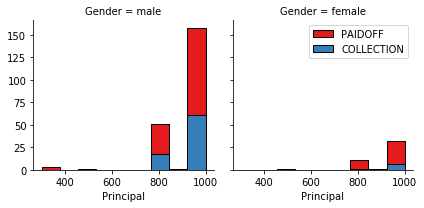

In [9]:
# Principal count by gender visual
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col = "Gender", hue = "Loan_Status", palette = "Set1", col_wrap = 2)
g.map(plt.hist, 'Principal', bins = bins, ec = "k")

g.axes[-1].legend()
plt.show()

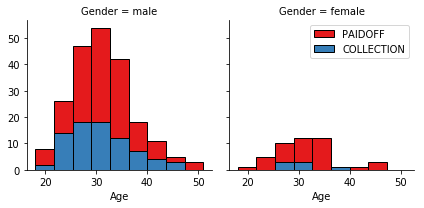

In [10]:
# Age count by gender visual
bins = np.linspace(df.Age.min(), df.Age.max(), 10)
g = sns.FacetGrid(df, col = "Gender", hue = "Loan_Status", palette = "Set1", col_wrap = 2)
g.map(plt.hist, 'Age', bins = bins, ec = "k")

g.axes[-1].legend()
plt.show()

We will take a look at the day of week to determine when people get a loan.

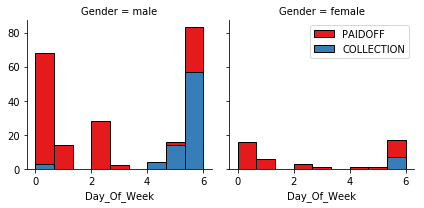

In [11]:
# Day of week count by gender visual 
df['Day_Of_Week'] = df['Effective_Date'].dt.dayofweek
bins = np.linspace(df.Day_Of_Week.min(), df.Day_Of_Week.max(), 10)
g = sns.FacetGrid(df, col = "Gender", hue = "Loan_Status", palette = "Set1", col_wrap = 2)
g.map(plt.hist, 'Day_Of_Week', bins = bins, ec = "k")

g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so let's use Feature binarization to set a threshold values less then day 4.

In [12]:
# Create specific column for weekend
df['Weekend'] = df['Day_Of_Week'].apply(lambda x: 1 if (x>3) else 0)
df.head()

,Loan_Status,Principal,Terms,Effective_Date,Due_Date,Age,Education,Gender,Day_Of_Week,Weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,College,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,College,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,College,male,4,1


## Pre-processing: feature selection/extraction

View features that will be used for our models:

In [13]:
df[['Principal', 'Terms', 'Age', 'Education', 'Gender', 'Weekend']].head()

,Principal,Terms,Age,Education,Gender,Weekend
0,1000,30,45,High School or Below,male,0
1,1000,30,33,Bachelor,female,0
2,1000,15,27,College,male,0
3,1000,30,28,College,female,1
4,1000,30,29,College,male,1


Lets look at gender:

In [14]:
df.groupby(['Gender'])['Loan_Status'].value_counts(normalize=True)

Gender  Loan_Status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.732877
        COLLECTION     0.267123
Name: Loan_Status, dtype: float64

86% of females compared to only 73% males pay their loans.

Lets look at education:

In [15]:
df.groupby(['Education'])['Loan_Status'].value_counts(normalize=True)

Education             Loan_Status
Bachelor              PAIDOFF        0.750000
                      COLLECTION     0.250000
College               PAIDOFF        0.765101
                      COLLECTION     0.234899
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Name: Loan_Status, dtype: float64

All education levels have the same percentage of likelihood to pay off their loans.

#### Feature engineering (one hot encoding)

In [25]:
# Convert gender to binary values
df['Gender'].replace({"male": 0, "female": 1}, inplace=True)

Feature = df[['Principal', 'Terms', 'Age', 'Gender', 'Weekend', 'Education']].copy()
Feature = pd.get_dummies(Feature, prefix = '', prefix_sep='')
Feature.head()

,Principal,Terms,Age,Gender,Weekend,Bachelor,College,High School or Below
0,1000,30,45,0,0,0,0,1
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,1,0
3,1000,30,28,1,1,0,1,0
4,1000,30,29,0,1,0,1,0


#### Convert feature set to numpy array

In [26]:
X = Feature.to_numpy(dtype = 'float32', copy = True)
X[:5]

array([[1000.,   30.,   45.,    0.,    0.,    0.,    0.,    1.],
       [1000.,   30.,   33.,    1.,    0.,    1.,    0.,    0.],
       [1000.,   15.,   27.,    0.,    0.,    0.,    1.,    0.],
       [1000.,   30.,   28.,    1.,    1.,    0.,    1.,    0.],
       [1000.,   30.,   29.,    0.,    1.,    0.,    1.,    0.]],
      dtype=float32)

#### Convert target labels to numpy array

In [33]:
y = df['Loan_Status'].replace({"PAIDOFF": 0, "COLLECTION": 1}).to_numpy(copy = True) # Convert our target variable to binary (PAIDOFF: 0, COLLECTION: 1)
y[:5]

array([0, 0, 0, 0, 0])

## Normalize Data

We need to split our dataset into train and test sets to determine which K-value is the best for our K-nearest neighbor model.

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 1)

print("Train set: ", X_train.shape, y_train.shape)
print("Test set: ", X_test.shape, y_test.shape)

Train set:  (240, 8) (240,)
Test set:  (104, 8) (104,)


Data Standardization give data zero mean and unit variance.

In [35]:
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_full_train = StandardScaler().fit(X).transform(X) # full feature set

print("Train: ", X_train[:2], "\n")
print("Test: ", X_test[:2])

Train:  [[ 0.510258   -0.9200219  -0.6439651   2.305597    0.83074635 -0.41319734
   1.1243446  -0.83793086]
 [ 0.510258    0.95651    -1.5171382  -0.4337262   0.83074635 -0.41319734
  -0.8894069   1.1934167 ]] 

Test:  [[ 0.510258    0.95651    -0.46933052 -0.4337262   0.83074635 -0.41319734
  -0.8894069   1.1934167 ]
 [-1.2267905  -0.9200219   1.4516503  -0.4337262  -1.2037344  -0.41319734
   1.1243446  -0.83793086]]


## ML Classification

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

## K Nearest Neighbor (KNN)
*Notice*: You should find the best k to build the model with the best accuracy.  
**Warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Number Ks used will be 10
mean_acc = np.zeros(10)
std_acc = np.zeros(10)

# Store values to determine which K provides the best accuracy
for i in range(10):
    loan_knn = KNeighborsClassifier(n_neighbors = (i + 1)).fit(X_train, y_train)
    y_pred = loan_knn.predict(X_test)
         
    mean_acc[i] = metrics.accuracy_score(y_test, y_pred)
    std_acc[i] = np.std(y_pred == y_test) / np.sqrt(y_pred.shape[0])

#### Plot model accuracy for different number of neighbors

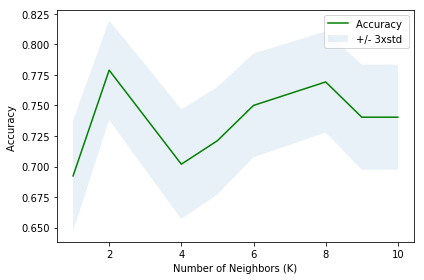

In [37]:
plt.plot(range(1, 11), mean_acc, 'g')
plt.fill_between(range(1, 11), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [38]:
print("The best accuracy was with", mean_acc.max(), "with k =", mean_acc.argmax() + 1)

The best accuracy was with 0.7788461538461539 with k = 2


In [40]:
# Train data with most accurate K
loanKnn = KNeighborsClassifier(n_neighbors = 2).fit(X_full_train, y)

## Decision Tree

In [41]:
from sklearn.tree import DecisionTreeClassifier

# Train data
loanDecisionTree = DecisionTreeClassifier(criterion="entropy").fit(X_full_train[:,:5], y) # We will use the feature set without encoded columns for training

## Support Vector Machine

In [42]:
from sklearn.svm import SVC

# Train data
loanSVM = SVC(kernel = 'rbf', gamma = 'scale').fit(X_full_train, y) # We will use the feature set with encoded columns for training

## Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression

# Train data
loanLogisticReg = LogisticRegression(solver = 'liblinear').fit(X_full_train, y) # We will use the feature set with encoded columns for training

## Load test set for evaluation 

Download dataset from IBM Cognitive Class Object Storage.

In [44]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-05-20 23:30:42--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-05-20 23:30:42 (346 MB/s) - ‘loan_test.csv’ saved [3642/3642]



In [45]:
# Load data from CSV file
df_test = pd.read_csv('loan_test.csv', usecols = keep_columns, parse_dates = datetime_columns)
df_test.rename(columns = {'loan_status': 'Loan_Status', 'terms': 'Terms', 'effective_date': 'Effective_Date', 'due_date': 'Due_Date', 'age': 'Age', 'education': 'Education'}, inplace = True) # converting columns to lower case
df_test.head()

,Loan_Status,Principal,Terms,Effective_Date,Due_Date,Age,Education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


#### Prepare data for evaluation

In [46]:
# Correct spelling for values in education column
df_test.Education.replace({"Bechalor": "Bachelor", "college": "College"}, inplace = True)

# Remove Masters Degree records if any exist
df_test = df_test[df_test.Education != 'Master or Above']

In [47]:
# Create columns for day of the week and weekend flag
df_test['Day_Of_Week'] = df_test['Effective_Date'].dt.dayofweek
df_test['Weekend'] = df_test['Day_Of_Week'].apply(lambda x: 1 if (x>3) else 0)

# Convert gender to binary values
df_test['Gender'].replace({"male": 0, "female": 1}, inplace=True)

# One encode conversion for education attribute
Feature_test = df_test[['Principal', 'Terms', 'Age', 'Gender', 'Weekend', 'Education']].copy()
Feature_test = pd.get_dummies(Feature_test, prefix = '', prefix_sep='')
Feature_test.head()

,Principal,Terms,Age,Gender,Weekend,Bachelor,College,High School or Below
0,1000,30,50,1,0,1,0,0
2,1000,30,43,1,1,0,0,1
3,1000,30,26,0,1,0,1,0
4,800,15,29,0,1,1,0,0
5,700,15,33,0,1,0,0,1


#### Convert to numpy arrays

In [48]:
# Feature set
X_loan_test = Feature_test.to_numpy(dtype = 'float32', copy = True)

# Target labels
y_loan_test = df_test['Loan_Status'].replace({"PAIDOFF": 0, "COLLECTION": 1}).to_numpy(copy = True)

#### Normalize Data

In [49]:
X_full_test = StandardScaler().fit(X_loan_test).transform(X_loan_test) # full feature set
X_full_test[:5]

array([[ 0.48913425,  0.89844006,  3.0598512 ,  1.9306147 , -1.317893  ,
         2.3452077 , -0.8905636 , -0.82305497],
       [ 0.48913425,  0.89844006,  1.8911357 ,  1.9306147 ,  0.7587869 ,
        -0.42640144, -0.8905636 ,  1.214986  ],
       [ 0.48913425,  0.89844006, -0.94717324, -0.5179698 ,  0.7587869 ,
        -0.42640144,  1.1228845 , -0.82305497],
       [-1.1005521 , -0.8892723 , -0.44629517, -0.5179698 ,  0.7587869 ,
         2.3452077 , -0.8905636 , -0.82305497],
       [-1.8953953 , -0.8892723 ,  0.22154222, -0.5179698 ,  0.7587869 ,
        -0.42640144, -0.8905636 ,  1.214986  ]], dtype=float32)

## Model Evaluation using test set

In [50]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

evaluation_df = pd.DataFrame(columns = ['Algorithm', 'Jaccard', 'F1-Score', 'LogLoss']) # Create dataframe to store all evaluation metrics

In [51]:
# Predict with K-Nearest Neighbor
predKnn = loanKnn.predict(X_full_test)

# Append evaluation metrics to dataframe
evaluation_df = evaluation_df.append({'Algorithm': "KNN", 'Jaccard': jaccard_similarity_score(y_loan_test, predKnn), 
                                      'F1-Score': f1_score(y_loan_test, predKnn, average='weighted'), 'LogLoss': None}, ignore_index = True)

In [52]:
# Predict with Decision Tree
predDecisionTree = loanDecisionTree.predict(X_full_test[:,:5])

# Append evaluation metrics to dataframe
evaluation_df = evaluation_df.append({'Algorithm': "Decision Tree", 'Jaccard': jaccard_similarity_score(y_loan_test, predDecisionTree), 
                                      'F1-Score': f1_score(y_loan_test, predDecisionTree, average='weighted'), 'LogLoss': None}, ignore_index = True)

In [53]:
# Predict with Support Vector Machines
predSVM = loanSVM.predict(X_full_test)

# Append evaluation metrics to dataframe
evaluation_df = evaluation_df.append({'Algorithm': "SVM", 'Jaccard': jaccard_similarity_score(y_loan_test, predSVM), 
                                      'F1-Score': f1_score(y_loan_test, predSVM, average='weighted'), 'LogLoss': None}, ignore_index = True)

In [54]:
# Predict Logistic Regression
predLogisticReg = loanLogisticReg.predict(X_full_test)
predLogisticRegProb = loanLogisticReg.predict_proba(X_full_test)

# Append evaluation metrics to dataframe
evaluation_df = evaluation_df.append({'Algorithm': "Logistic Regression", 'Jaccard': jaccard_similarity_score(y_loan_test, predLogisticReg), 
                                      'F1-Score': f1_score(y_loan_test, predLogisticReg, average='weighted'), 'LogLoss': log_loss(y_loan_test, predLogisticRegProb)}, ignore_index = True)

## Display evaluation metrics for all models

In [55]:
evaluation_df

,Algorithm,Jaccard,F1-Score,LogLoss
0,KNN,0.730769,0.689744,None
1,Decision Tree,0.750000,0.730542,None
2,SVM,0.711538,0.607606,None
3,Logistic Regression,0.750000,0.659925,0.486097


## Findings

My recommendation is to utilize the decision tree model for this dataset since it has the highest accuracy on both F1-score and Jaccard index.